In [2]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
sns.set()

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [57]:
def generate_data():
    n = 30
    x = np.random.random((n,1))
    f_x = 4*np.sin(np.pi*x)*np.cos(6*np.pi*(x**2))
    
    eps = np.random.randn(n,1)
    y = f_x + eps
    return x,y,f_x

def make_K_mat_rbf(x,gamma):
    K = np.zeros((x.shape[0],x.shape[0]))
    
    for i in np.arange(x.shape[0]):
        for j in np.arange(x.shape[0]):
            K[i][j] = np.exp(-gamma*(np.linalg.norm(x[i]-x[j])))
            
    return K

def make_K_mat_poly(x,d):
    K = np.zeros((x.shape[0],x.shape[0]))

    for i in np.arange(x.shape[0]):
        for j in np.arange(x.shape[0]):
            terms_to_eval = (1+np.dot(x[i].T,x[j]))
            K[i][j] = terms_to_eval**d
    return K

def kernel_eval_rbf(gamma,x_1,x_2):
    eval_kernel = []
    
    for i in np.arange(x_2.shape[0]):
        eval_iter = np.exp(-gamma*(np.linalg.norm(x_1-x_2[i])))
        eval_kernel.append(eval_iter)
    return eval_kernel 

def kernel_eval_poly(d,x_1,x_2):
    
    eval_kernel = []
         
    for i in np.arange(x_2.shape[0]):
        eval_iter = (1+np.dot(x_1.T,x_2[i]))**d
        eval_kernel.append(eval_iter)
        
    return eval_kernel

def alpha_hat_compute(K,lambda_val,y):
    
    lhs = K + lambda_val*np.identity(np.shape(K)[0])
    alpha_hat = np.linalg.solve(lhs,y)
    
    return alpha_hat

def choose_gamma(x):
    dist_vals = []
    for i in np.arange(x.shape[0]):
        for j in np.arange(i):
            dist_vals.append((np.linalg.norm(x[i] - x[j])))
            
    median_val = np.median(np.array(dist_vals))
    gamma = 1/median_val
    return gamma,dist_vals

def f_hat_compute(K,alpha_hat):
    f_hat = np.dot(alpha_hat,K)
    
    return f_hat

def LOOCV_rbf(x,y,lambda_vec):
    
    cost_vec = []
    gamma_vec = []
    
    for lambda_val in lambda_vec:
            score_ind = []
            gamma_ind = []
            
            for valid_ind in np.arange(y.shape[0]):
                mask = np.ones(np.shape(y))
                mask[valid_ind] = 0
                mask = mask.astype('bool')
                y_train = y[mask]
                y_test = y[valid_ind]
                x_train = x[mask]
                x_test = x[valid_ind]
                
                gamma,dist_vals = choose_gamma(x_train)
                K = make_K_mat_rbf(x_train,gamma)
                alpha_hat = alpha_hat_compute(K,lambda_val,y_train)
                f_hat = f_hat_compute(alpha_hat,K)
                
                #w_vec = np.dot(x_train,alpha_hat)
                #predict_y = np.dot(w_vec,x_test)
                
                eval_kernel = kernel_eval_rbf(gamma,x_test,x_train)
                predict_y = np.array([np.sum(alpha_hat*eval_kernel)])
                #import pdb;pdb.set_trace()
                cost_ind = cost_func(predict_y,y_test)
                gamma_ind.append(gamma)
                score_ind.append(cost_ind)
                import pdb;pdb.set_trace()


            score = (1/len(score_ind))*np.sum(score_ind)
            gamma_vec.append((1/len(score_ind))*np.sum(gamma_ind))
            
            cost_vec.append(score)
    
    return cost_vec,gamma_vec

def LOOCV_poly(x,y,lambda_vec,d_vec):
    
    cost_vec = np.zeros((lambda_vec.shape[0],d_vec.shape[0]))
    lambda_iter = 0

    
    for lambda_val in lambda_vec:
        
        d_iter = 0
        for d_ind in d_vec:
            score_ind = []
            
            for valid_ind in np.arange(y.shape[0]):
                mask = np.ones(np.shape(y))
                mask[valid_ind] = 0
                mask = mask.astype('bool')
                y_train = y[mask]
                y_test = y[valid_ind]
                x_train = x[mask]
                x_test = x[valid_ind]

                K = make_K_mat_poly(x_train,d_ind)
                alpha_hat = alpha_hat_compute(K,lambda_val,y_train)
                f_hat = f_hat_compute(alpha_hat,K)

                #w_vec = np.dot(x_train,alpha_hat)
                #predict_y = np.dot(w_vec,x_test)

                eval_kernel = kernel_eval_poly(d_ind,x_test,x_train)
                predict_y = np.array([np.sum(alpha_hat*eval_kernel)])
                #import pdb;pdb.set_trace()
                cost_ind = cost_func(predict_y,y_test)
                score_ind.append(cost_ind)
                import pdb;pdb.set_trace()

            
            score = (1/len(score_ind))*np.sum(score_ind)
            cost_vec[lambda_iter][d_iter] = score
            
            d_iter += 1 
        
        lambda_iter += 1
    
    return cost_vec

def cost_func(prediction,truth):
    
    cost = []
    
    for i in np.arange(prediction.shape[0]):
        
        cost.append(np.linalg.norm(prediction[i]-truth[i]))
    
    cost_total = np.sqrt(np.sum(cost))
    return cost_total

def plot_function_rbf(x,y,f_x,f_hat,kernel,lambda_val,gamma):
    #plt.figure(dpi=600)
    plt.figure()
    plt.plot(x,y,'o',label='original data with noise')
    plt.plot(x,f_x,'o',label='true f(x)')
    plt.plot(x,f_hat,'o',label='f_hat(x)')
    plt.xlabel('x')
    plt.title('Data, f(x), and f_hat_x \n for kernel = {}, lambda = {}, gamma = {:.2f}'.format(kernel,lambda_val,gamma))
    plt.legend()
    #plt.savefig('hw3_prob2_'.format{kernel})
    
def plot_function_poly(x,y,f_x,f_hat,kernel,lambda_val,d):
    #plt.figure(dpi=600)
    plt.figure()
    plt.plot(x,y,'o',label='original data with noise')
    plt.plot(x,f_x,'o',label='true f(x)')
    plt.plot(x,f_hat,'o',label='f_hat(x)')
    plt.xlabel('x')
    plt.title('Data, f(x), and f_hat_x \n for kernel = {}, lambda = {}, d = {}'.format(kernel,lambda_val,d))
    plt.legend()
    #plt.savefig('hw3_prob2_'.format{kernel})

### generate data

In [4]:
x,y,f_x = generate_data()


### polynomial kernel

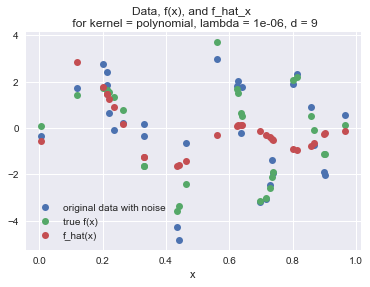

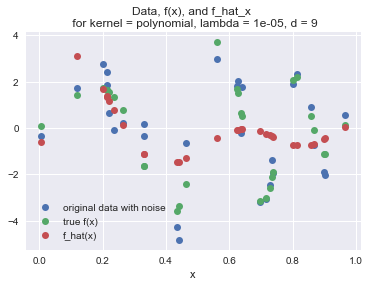

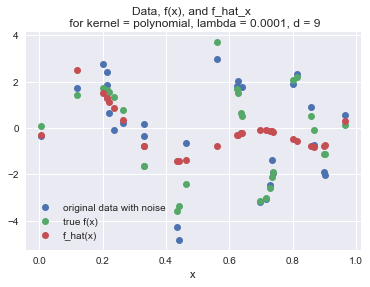

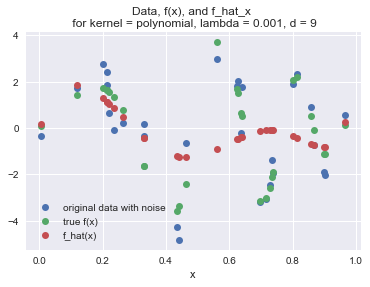

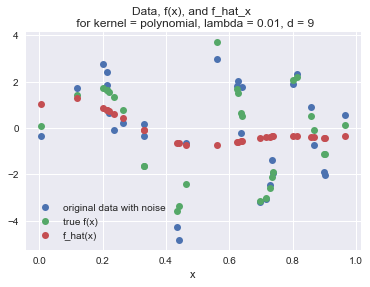

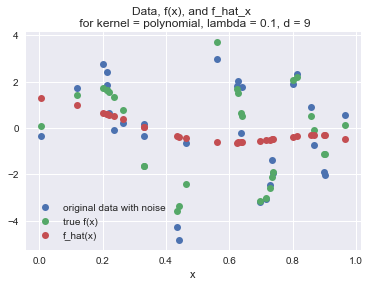

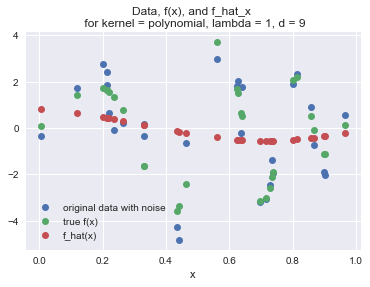

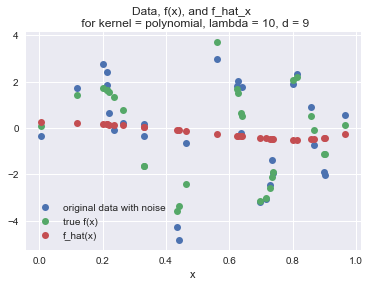

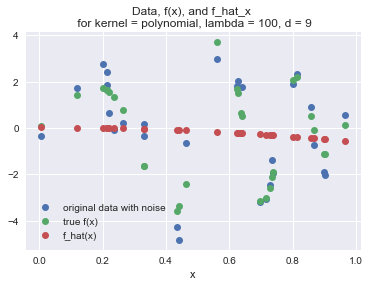

In [48]:
d_vec = np.arange(1,10)

for d in d_vec:
    
    K = make_K_mat_poly(x,d)
    
lambda_vec = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100]

for lambda_val in lambda_vec:
    alpha_hat = alpha_hat_compute(K,lambda_val,y)
    f_hat = f_hat_compute(alpha_hat,K)
    plot_function_poly(x,y,f_x,f_hat,'polynomial',lambda_val,d)

array([ 33.92813945])

array([[ 0.42753373],
       [-0.25913843],
       [ 0.44033823],
       [-0.14668471],
       [-0.55125629],
       [-0.57238489],
       [-0.44579845],
       [ 0.01753313],
       [ 0.46160124],
       [-0.42651567],
       [-0.27617914],
       [ 0.24139042],
       [ 0.24156434],
       [-0.37467075],
       [ 0.06600593],
       [-0.72156424],
       [-0.25540224],
       [-0.44125947],
       [-0.40699116],
       [ 0.05399927],
       [-0.82996015],
       [-0.71725441],
       [ 0.59925168],
       [ 0.3568086 ],
       [ 0.44088581],
       [-0.6448156 ],
       [ 0.40325228],
       [-0.27863121],
       [ 0.79222756],
       [-0.66419026]])

array([[  234750.44624101],
       [ 2294616.92405852],
       [ 1421813.56710386],
       [ 3105054.48186975],
       [ 2452438.53512176],
       [ 2880300.08220488],
       [-1479062.39902588],
       [ -682231.59858769],
       [ 2275993.98548936],
       [-2039869.91565801],
       [   78379.71146971],
       [  -73523.76690125],
       [ -605335.99059213],
       [-2817478.99366732],
       [-4348845.60547438],
       [-1288712.81875041],
       [ 2041826.35235909],
       [ -961105.41261855],
       [-2641823.05102401],
       [-4883461.22943149],
       [ 1382713.80768695],
       [-1172507.92981574],
       [ 1137519.50463224],
       [ -144106.73475444],
       [ 1957949.34473306],
       [ 1562719.36375084],
       [ -511603.97215874],
       [ 2060642.32587149],
       [-1161168.58768681],
       [  -75879.62593084]])

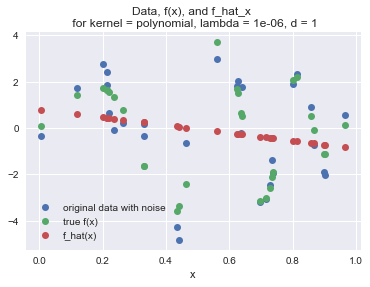

In [62]:
d = 1
lambda_val = 1e-6
    
K = make_K_mat_poly(x,d)
    


alpha_hat = alpha_hat_compute(K,lambda_val,y)
f_hat = f_hat_compute(alpha_hat,K)
plot_function_poly(x,y,f_x,f_hat,'polynomial',lambda_val,d)

eval_kernel = kernel_eval_poly(d,x[0:-1],x[-1])
predict_y = np.array([np.sum(alpha_hat*eval_kernel)])
predict_y

np.dot(K,alpha_hat)
alpha_hat_compute(K,lambda_val,y)

In [51]:
alpha_hat

array([[  234750.44624101],
       [ 2294616.92405852],
       [ 1421813.56710386],
       [ 3105054.48186975],
       [ 2452438.53512176],
       [ 2880300.08220488],
       [-1479062.39902588],
       [ -682231.59858769],
       [ 2275993.98548936],
       [-2039869.91565801],
       [   78379.71146971],
       [  -73523.76690125],
       [ -605335.99059213],
       [-2817478.99366732],
       [-4348845.60547438],
       [-1288712.81875041],
       [ 2041826.35235909],
       [ -961105.41261855],
       [-2641823.05102401],
       [-4883461.22943149],
       [ 1382713.80768695],
       [-1172507.92981574],
       [ 1137519.50463224],
       [ -144106.73475444],
       [ 1957949.34473306],
       [ 1562719.36375084],
       [ -511603.97215874],
       [ 2060642.32587149],
       [-1161168.58768681],
       [  -75879.62593084]])

### rbf kernel

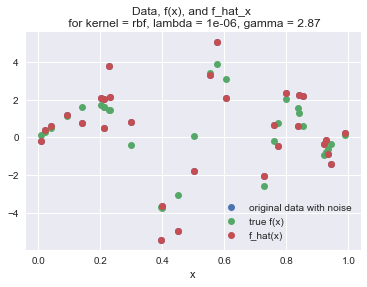

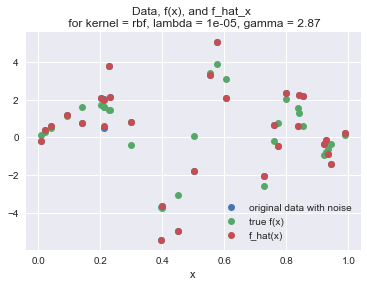

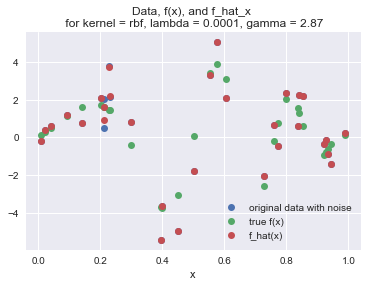

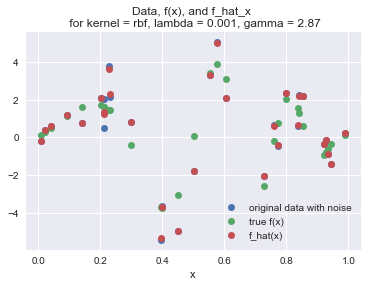

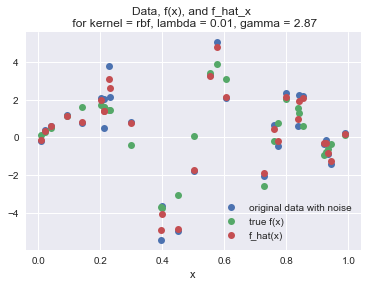

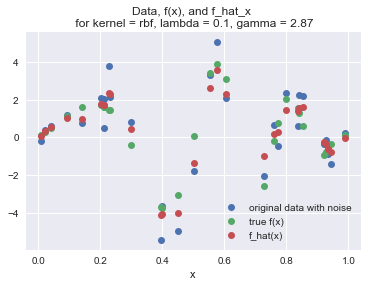

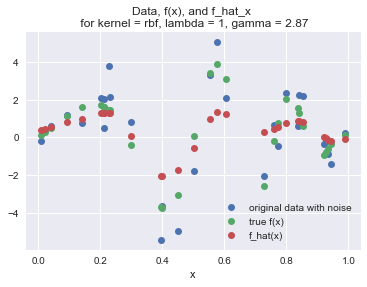

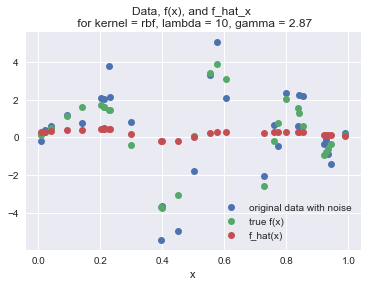

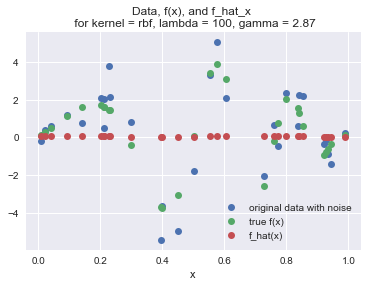

In [45]:
# choose gamma 
gamma,dist_vals = choose_gamma(x)


K = make_K_mat_rbf(x,gamma)

lambda_vec = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100]

for lambda_val in lambda_vec:
    alpha_hat = alpha_hat_compute(K,lambda_val,y)
    f_hat = f_hat_compute(alpha_hat,K)
    plot_function_rbf(x,y,f_x,f_hat,'rbf',lambda_val,gamma)

### try cross validation - polynomial

In [36]:
lambda_vec = np.array([1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100])
d_vec = np.arange(1,30,3)

score_vec = LOOCV_poly(x,y,lambda_vec,d_vec)

> <ipython-input-35-4a56b6099a49>(122)LOOCV_poly()
-> for valid_ind in np.arange(y.shape[0]):
(Pdb) cost_ind
4.9445853990937048
(Pdb) y_test
array([ 0.66228417])
(Pdb) predict_y
array([ 25.11120894])
(Pdb) d
*** Newest frame
(Pdb) d_ind
1
(Pdb) x_train
array([ 0.62791583,  0.21342886,  0.56127943,  0.80101531,  0.81353543,
        0.73852444,  0.46396931,  0.2008291 ,  0.7270981 ,  0.63801359,
        0.33131881,  0.33121576,  0.6963765 ,  0.43524592,  0.90193423,
        0.62570188,  0.7358348 ,  0.71552852,  0.44236068,  0.96616609,
        0.89938036,  0.11926195,  0.26292578,  0.21310438,  0.85645549,
        0.23540478,  0.63946661,  0.00491076,  0.86793628])
(Pdb) x_test
array([ 0.22101639])
(Pdb) alpha_hat
array([ 2299913.42602753,  1442802.92553296,  3112873.89835923,
        2451181.33406947,  2878568.85539368, -1477953.63850195,
        -670727.92623568,  2297460.38267574, -2038328.54228865,
          83293.90295172,   -56997.83168849,  -588806.1518443 ,
       -2814774.47681

(Pdb) K.shape
(29, 29)
(Pdb) alpha_hat.shape
(29,)
(Pdb) y_train
array([ 2.0354785 ,  1.8621518 ,  2.95836978,  1.90118225,  2.30791519,
       -1.92486084, -0.66469845,  2.73759523, -2.46638558, -0.19779943,
        0.16786666, -0.36377165, -3.19214974, -4.28283967, -2.01027706,
        1.78642412, -1.40236488, -3.04881421, -4.82946195,  0.55275366,
       -1.88976234,  1.73677118,  0.21270187,  2.39883516,  0.91790377,
       -0.10835169,  1.78201112, -0.36894103, -0.74006989])
(Pdb) y_test
array([ 0.66228417])
(Pdb) predict_y
array([ 25.11120894])
(Pdb) q


BdbQuit: 

In [23]:
np.argmin(score_vec)

80

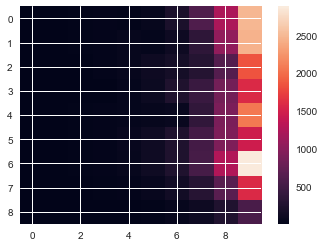

In [25]:
plt.imshow(score_vec)
plt.colorbar()

### try cross validation - rbf

In [39]:
lambda_vec = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100]


score_vec,gamma_vec = LOOCV_rbf(x,y,lambda_vec)

> <ipython-input-37-6101f7eb02fc>(77)LOOCV_rbf()
-> for valid_ind in np.arange(y.shape[0]):
(Pdb) K
array([[ 1.        ,  0.21619384,  0.78174272,  0.5274909 ,  0.50364327,
         0.66450537,  0.54563646,  0.20635908,  0.69316266,  0.96337505,
         0.3342179 ,  0.33409065,  0.77649077,  0.49069194,  0.36329817,
         0.99185258,  0.67114253,  0.72343862,  0.50376323,  0.28654033,
         0.36674278,  0.15266061,  0.25958198,  0.21593478,  0.42977996,
         0.23448207,  0.95821648,  0.10005056,  0.41192877],
       [ 0.21619384,  1.        ,  0.2765537 ,  0.11404028,  0.10888457,
         0.14366197,  0.39622323,  0.95450952,  0.1498575 ,  0.20827575,
         0.64686494,  0.64711131,  0.16787252,  0.44058976,  0.07854283,
         0.21796973,  0.14509688,  0.15640297,  0.42915764,  0.06194826,
         0.07928753,  0.7061284 ,  0.83285381,  0.99880174,  0.09291578,
         0.92200585,  0.2071605 ,  0.46278172,  0.08905646],
       [ 0.78174272,  0.2765537 ,  1.        ,  

(Pdb) q


BdbQuit: 

In [28]:
score_vec

[0.85871425623328057,
 0.85871745859621862,
 0.85875509821813767,
 0.85804320400550127,
 0.85831042247383915,
 0.97118500814440956,
 1.1505789640000617,
 1.1939364803055152,
 1.2124167515479154]

In [31]:
np.argmin(score_vec)

3

In [29]:
best_gamma = gamma_vec[np.argmin(score_vec)]
best_lambda = lambda_vec[np.argmin(score_vec)]

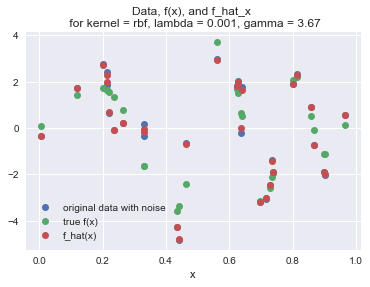

In [30]:
K = make_K_mat_rbf(x,best_gamma)


alpha_hat = alpha_hat_compute(K,best_lambda,y)
f_hat = f_hat_compute(alpha_hat,K)
plot_function_rbf(x,y,f_x,f_hat,'rbf',best_lambda,best_gamma)